# NEMD Thermal Transport
This example is originally from [GPUMD](https://github.com/brucefan1983/GPUMD) and has been added here with minor changes only to demonstrate how to use [gpyumd](https://github.com/AlexGabourie/gpyumd).

## 1. Introduction
- In this tutorial, we use the NEMD method to study heat transport in graphene at 300 K and zero pressure. Here we consider the ballistic regime. The diffusive regime can be found in the HNEMD example. The spectral decomposition method as described in [[Fan 2019]](https://doi.org/10.1103/PhysRevB.99.064308) is used here.

### Importing Relevant Functions
- The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [thermo](https://github.com/AlexGabourie/thermo) package.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from gpyumd.atoms import GpumdAtoms
from gpyumd.load import load_shc, load_compute
from ase.build import graphene_nanoribbon
from gpyumd.sim import Simulation
import gpyumd.keyword as kwd

## 2. Preparing the Inputs
- We consider a graphene sheet of size of about 25 nm x 43 nm (40400 atoms). The transport is in the $y$ direction. We divide the length in the $y$ direction into 9 groups. Group 0 (a small one) will be fixed. Group 1 (about 9 nm long) will act as a heat source and group 8 (about 9 nm long) will act as a sink. The remaining middle part is evenly divided into a few groups (group 2 to group 7).
- We use a Tersoff potential [[Tersoff 1989]](https://doi.org/10.1103/PhysRevB.39.5566) parameterized by Lindsay *et al.* [[Lindsay 2010]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.205441).

In [2]:
gnr = GpumdAtoms(graphene_nanoribbon(100, 101, type='armchair', sheet=True, vacuum=3.35/2, C_C=1.44))
gnr.euler_rotate(theta=90)
lx, lz, ly = gnr.cell.lengths()
gnr.cell = gnr.cell.new((lx, ly, lz))
gnr.center()
gnr.pbc = [True, True, False]
gnr.set_cutoff(2.1)
gnr.set_max_neighbors(3)
gnr

GpumdAtoms(symbols='C40400', pbc=[True, True, False], cell=[249.41531628991828, 436.32000000000005, 3.35])

### Add groups for NEMD

In [3]:
split = np.array([ly/100] + [ly/5] + [ly/10]*6)-0.4
split = [0] + list(np.cumsum(split)) + [ly]
print("y-direction boundaries:", [round(x,2) for x in split])

y-direction boundaries: [0, 3.96, 90.83, 134.06, 177.29, 220.52, 263.76, 306.99, 350.22, 436.32]


In [4]:
group_method, ncounts = gnr.group_by_position(split, direction='y')
ncounts

array([ 400, 8000, 4000, 4000, 4000, 4000, 4000, 4000, 8000])

In [5]:
gnr.sort_atoms(sort_key='group', group_method=group_method, order=list(range(len(ncounts))))

### The <code>run.in</code> file:
The [gpyumd](https://github.com/AlexGabourie/gpyumd) package can be used to generate valid <code>run.in</code> input files as well as other necessary input files. It follows the definitions described in the [inputs and outputs](https://gpumd.zheyongfan.org/index.php/Main_Page#Inputs_and_outputs_for_GPUMD) documentation for <code>GPUMD</code>.

In [6]:
nemd_sim = Simulation(gnr, driver_directory='.')

In [7]:
# Equilibration run
header_comment = "Equilibration"
curr_run = nemd_sim.add_run(number_of_steps=1e5, run_name='equilibration', run_header=header_comment)

# Create ensemble for the equilibration
npt_condition = 'orthogonal'
pdict = kwd.Ensemble.get_npt_pdict(condition=npt_condition)
pdict['p_xx'], pdict['p_yy'], pdict['p_zz'] = [0]*3  # GPa
pdict['C_xx'], pdict['C_yy'], pdict['C_zz'] = [53.4059]*3  # GPa

npt_ensemble = kwd.Ensemble(ensemble_method='npt_ber')
npt_ensemble.set_npt_parameters(initial_temperature=300, final_temperature=300, thermostat_coupling=100, 
                                barostat_coupling=2000, condition=npt_condition, pdict=pdict)

keywords = [
    kwd.Velocity(initial_temperature=300),
    kwd.Fix(group_id=0),
    npt_ensemble,
    kwd.TimeStep(dt_in_fs=1),
    kwd.NeighborOff(),
    kwd.DumpThermo(1000)
]

for keyword in keywords:
    curr_run.add_keyword(keyword)

In [8]:
# Equilibration run
curr_run = nemd_sim.add_run(number_of_steps=1e6, run_name='nemd')

# Create ensemble for the equilibration
heat_ensemble = kwd.Ensemble(ensemble_method='heat_lan')
heat_ensemble.set_heat_parameters(temperature=300, thermostat_coupling=100, temperature_delta=10, 
                                  source_group_id=1, sink_group_id=8)

keywords = [
    kwd.Fix(group_id=0),
    heat_ensemble,
    kwd.NeighborOff(),
    kwd.Compute(grouping_method=group_method, sample_interval=10, output_interval=100, temperature=True),
    kwd.ComputeSHC(sample_interval=2, num_corr_steps=250, transport_direction='y', \
                   num_omega=1000, max_omega=400.0, grouping_method=group_method, group_id=4),
]

for keyword in keywords:
    curr_run.add_keyword(keyword)

In [9]:
potential_directory = "/path/to/GPUMD/potentials/tersoff"
tersoff_potential = \
    kwd.Potential(filename='Graphene_Lindsay_2010_modified.txt', symbols=['C'], directory=potential_directory)
nemd_sim.add_potential(tersoff_potential)

In [10]:
nemd_sim.create_simulation(copy_potentials=True)

The <code>run.in</code> input file is given below:<br>
```
potential Graphene_Lindsay_2010_modified.txt 0

# Equilibration
time_step 1 
velocity 300 
fix 0 
ensemble npt_ber 300 300 100 0 0 0 53.4059 53.4059 53.4059 2000 
neighbor off 
dump_thermo 1000 
run 100000 

fix 0 
ensemble heat_lan 300 100 10 1 8 
neighbor off 
compute 0 10 100 temperature 
compute_shc 2 250 1 1000 400.0 group 0 4
run 1000000 
```

- The first line uses the [potential](https://gpumd.zheyongfan.org/index.php/The_potential_keyword) keyword to define the potential to be used, which is specified in the file [Graphene_Lindsay_2010_modified.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Graphene_Lindsay_2010_modified.txt).

- The second line uses the [velocity](https://gpumd.zheyongfan.org/index.php/The_velocity_keyword) keyword and sets the velocities to be initialized with a temperature of 300 K. 

- There are two runs. The first [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) serves as the equilibration stage.
  - Here, the NVT [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) (the Berendsen thermostat) is used. The target temperature is 300 K and the coupling constant is 100 time steps for the thermostat. 
  - The [time_step](https://gpumd.zheyongfan.org/index.php/The_time_step_keyword) for integration is 1 fs. 
  - Atoms in group 0 will be fixed. 
  - The thermodynamic quantities will be output every 1000 steps. 
  - There are $10^5$ steps (100 ps) for this run. 
- The second [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) is for production. 
  - Here, two local Langevin thermostats ([ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword)) are applied to generate a nonequilibrium heat current. The time parameter in the Langevin thermostats is 0.1 ps (100 time steps). The target temperature of the heat source is $300+10=310$ K and the target temperature of the heat sink is $300-10=290$ K. Atoms in group 1 are in the heat source region and atoms in group 8 are in the heat sink region.
  - Atoms in group 0 will be fixed. 
  - The [compute](https://gpumd.zheyongfan.org/index.php/The_compute_keyword) is used to compute the group temperatures and energy transfer rate. Here, grouping method 0 is used, and the relevant data are sampled every 10 time steps and averaged for every 100 data points before written out. 
  - The line with the [compute_shc](https://gpumd.zheyongfan.org/index.php/The_compute_shc_keyword) keyword is used to compute the spectral heat current (SHC). The SHC will be calculated for group <code>4</code> in grouping method <code>0</code>. The relevant data will be sampled every 2 steps and the maximum correlation time is $250 \times 2 \times 1~{\rm fs} = 500~{\rm fs}$. The transport directions is <code>1</code> ($y$ direction). The number of frequency points is 1000 and the maximum angular frequncy is 400 THz.
  - There are $10^6$ steps (1 ns) in the production [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword). This is just an example. To get more accurate results, we suggest you use $10^7$ steps (10 ns).

## 3. Results and Discussion
### Computation Time
- The NEMD simulation takes about 20 minutes on a mobile GeForce RTX 2070 GPU and ~4 minuts on a Tesla V100.

### Figure Properties

In [11]:
aw = 2
fs = 16
font = {'size'   : fs}
plt.rc('font', **font)
plt.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    ax_list = ax_list if isinstance(ax_list, list) else [ax_list]
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

### Plot NEMD Results
 - The [compute.out](https://gpumd.zheyongfan.org/index.php/The_compute_keyword) output file is loaded and processed to create the following figure.

In [12]:
compute = load_compute(['temperature'])
compute.keys()

dict_keys(['Ein', 'Eout', 'm', 'temperature'])

In [13]:
T = compute['temperature']
Ein = compute['Ein']
Eout = compute['Eout']
ndata = T.shape[0]
temp_ave = np.mean(T[int(ndata/2)+1:, 1:], axis=0)

dt = 0.001  # ps 
Ns = 1000  # Sample interval
t = dt*np.arange(1,ndata+1) * Ns/1000  # ns

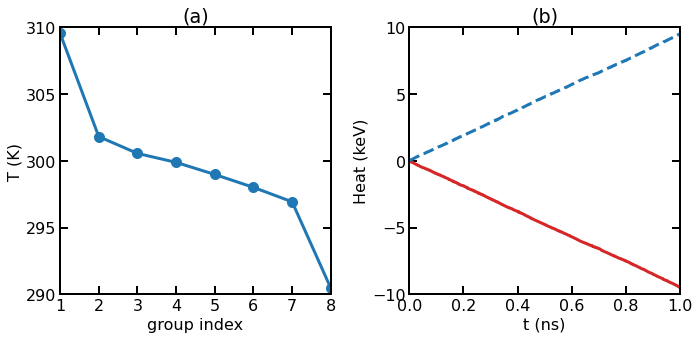

In [14]:
axes = list()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
axes.append(plt.gca())
group_idx = range(1,9)
plt.plot(group_idx, temp_ave,linewidth=3,marker='o',markersize=10)
plt.xlim([1, 8])
plt.gca().set_xticks(group_idx)
plt.ylim([290, 310])
plt.gca().set_yticks(range(290,311,5))
plt.xlabel('group index')
plt.ylabel('T (K)')
plt.title('(a)')

plt.subplot(1,2,2)
axes.append(plt.gca())
plt.plot(t, Ein/1000, 'C3', linewidth=3)
plt.plot(t, Eout/1000, 'C0', linewidth=3, linestyle='--' )
plt.xlim([0, 1])
plt.gca().set_xticks(np.linspace(0,1,6))
plt.ylim([-10, 10])
plt.gca().set_yticks(range(-10,11,5))
plt.xlabel('t (ns)')
plt.ylabel('Heat (keV)')
plt.title('(b)')

set_fig_properties(axes)
plt.tight_layout()
plt.show()

**(a)** Temperature profile in the NEMD simulation. **(b)** Energies accumulated in the thermostats.

- The figure above shows the temperature profile and the energies accumulated in the thermostats. The energy of the thermostat coupling to the heat source region is decreasing, because energy is transferred from the thermostat to the atoms in the source region. The energy of the thermostat coupling to the heat sink region is increasing, because energy is transferred from the atoms in the sink region to the thermostat. The absolute values of the slopes of the lines in **(b)** should be the same; otherwise it means energy is not conserved. The absolute slope is the energy transfer rate $Q=dE/dt$.
- The thermal conductance in this system can be calculated as
$$
G = \frac{Q/S}{\Delta T}
$$
where $S$ is the cross-sectional area and $\Delta T$ is the temperature difference, which is 19 K here (slightly smaller than the target value of 20 K). The calculated thermal conductance is about 10 GW m<sup>-2</sup> K<sup>-1</sup>. This is the classical value.

In [15]:
deltaT = temp_ave[0] - temp_ave[-1]  # [K]
deltaT

19.09111102204406

In [16]:
Q1 = (Ein[int(ndata/2)] - Ein[-1])/(ndata/2)/dt/Ns
Q2 = (Eout[-1] - Eout[int(ndata/2)])/(ndata/2)/dt/Ns
Q = np.mean([Q1, Q1])  # [eV/ps]
Q

9.420485999999999

In [17]:
l = gnr.cell.lengths()
A = l[0]*l[2]/100  # [nm2]
G = 160*Q/deltaT/A  # [GW/m2/K]
G

9.44918085634856

### Plot Spectral Heat Current Results
 - The [shc.out](https://gpumd.zheyongfan.org/index.php/The_shc.out_output_file) output file is loaded and processed to create the following figure.

In [18]:
shc = load_shc(250, 1000)['run0']
shc.keys()

dict_keys(['t', 'Ki', 'Ko', 'nu', 'jwi', 'jwo'])

In [19]:
Ly = split[5]-split[4]
Lx, Lz = l[0], l[2]
V = Lx*Ly*Lz
Gc = 1.6e4*(shc['jwi']+shc['jwo'])/V/deltaT

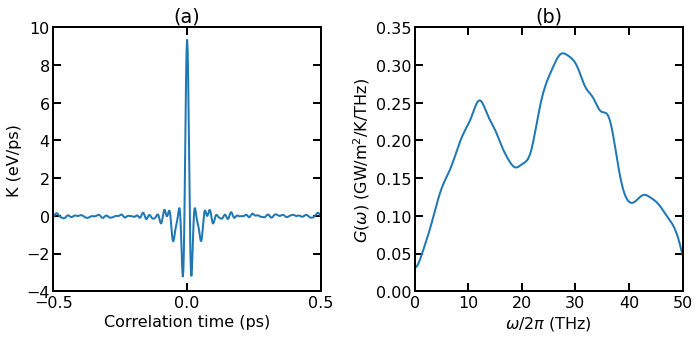

In [20]:
axes = list()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
axes.append(plt.gca())
plt.plot(shc['t'], (shc['Ki']+shc['Ko'])/Ly, linewidth=2)
plt.xlim([-0.5, 0.5])
plt.gca().set_xticks([-0.5, 0, 0.5])
plt.ylim([-4, 10])
plt.gca().set_yticks(range(-4,11,2))
plt.ylabel('K (eV/ps)')
plt.xlabel('Correlation time (ps)')
plt.title('(a)')

plt.subplot(1,2,2)
axes.append(plt.gca())
plt.plot(shc['nu'], Gc, linewidth=2)
plt.xlim([0, 50])
plt.gca().set_xticks(range(0,51,10))
plt.ylim([0, 0.35])
plt.gca().set_yticks(np.linspace(0,0.35,8))
plt.ylabel(r'$G$($\omega$) (GW/m$^2$/K/THz)')
plt.xlabel(r'$\omega$/2$\pi$ (THz)')
plt.title('(b)')

set_fig_properties(axes)
plt.tight_layout()
plt.show()

**(a)** Virial-velocity correlation function. **(b)** Spectral thermal conductance.

- The figure above shows the virial-velocity correlation function $K(t)$ and the spectral thermal conductance $G(\omega)$. See [Theoretical formulations](https://gpumd.zheyongfan.org/index.php/Theoretical_formulations) for the definitions of these quantities. Using the spectral thermal conductance, one can perform quantum correction, see [[Li 2019]](https://doi.org/10.1063/1.5132543).

In [21]:
np.save('Gc.npy', Gc)

## 4. References
- [Fan 2019] Zheyong Fan, Haikuan Dong, Ari Harju, and Tapio Ala-Nissila, [Homogeneous nonequilibrium molecular dynamics method for heat transport and spectral decomposition with many-body potentials](https://doi.org/10.1103/PhysRevB.99.064308), Phys. Rev. B **99**, 064308 (2019).
- [Li 2019] Zhen Li, Shiyun Xiong, Charles Sievers, Yue Hu, Zheyong Fan, Ning Wei, Hua Bao, Shunda Chen, Davide Donadio, and Tapio Ala-Nissila, [Influence of Thermostatting on Nonequilibrium Molecular Dynamics Simulations of Heat Conduction in Solids](https://doi.org/10.1063/1.5132543), J. Chem. Phys. **151**, 234105 (2019).
- [Lindsay 2010] L. Lindsay and D.A. Broido, [Optimized Tersoff and Brenner emperical potential parameters for lattice dynamics and phonon thermal transport in carbon nanotubes and graphene](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B, **81**, 205441 (2010).
- [Tersoff 1989] J. Tersoff, [Modeling solid-state chemistry: Interatomic potentials for multicomponent systems](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B 39, 5566(R) (1989).